In [1]:
import heapq
import numpy as np
from numba import njit
from copy import copy
import matplotlib.pyplot as plt
import matplotlib as m
import skfmm
from time import time

In [2]:
@njit()
def A_STAR_run(grid, p1, p2, dist_cost_map, k_dist_cost,  value, priority_queue, visited, transitions):
    x_max, y_max = grid.shape

    dxy = [[0,1], [1,0], [-1,0], [0,-1], [1,1], [1,-1], [-1,1], [-1,-1]]
    
    while priority_queue:
        cur_cost, (cur_x, cur_y) = heapq.heappop(priority_queue)
        if cur_x == p2[0] and cur_y == p2[1]:
            break
        
        if visited[cur_x, cur_y]:
            continue
        
        for dx, dy in dxy:
            x, y = cur_x + dx, cur_y + dy
            if abs(dx)+abs(dy)==2: L=np.sqrt(2)
            else: L=1
            if x < 0 or x >= x_max or y < 0 or y >= y_max:
                continue                
            
            if grid[x,y]: continue

            if ~visited[x,y]:
                dist_cost = k_dist_cost*dist_cost_map[x,y]# activate to get smoothed A*, else 0
                if value[cur_x, cur_y] + L + dist_cost < value[x,y]:       
                    
                    value[x,y] = value[cur_x,cur_y] + L + dist_cost
                    cart_distance = np.sqrt( (p2[0]-x)**2 + (p2[1]-y)**2 ) # activate to get A*
                    heuristic = value[x,y]  + cart_distance
                    heapq.heappush(priority_queue, (heuristic, (x, y)))
                    transitions[x,y,0] = cur_x
                    transitions[x,y,1] = cur_y

        visited[cur_x,cur_y] = 1
        
    # retrieve the path
    cur_x, cur_y = p2[0], p2[1]
    on_path = []
    on_path.append((cur_x,cur_y))

    while (cur_x, cur_y) != (p1[0], p1[1]):
        cur_x, cur_y = transitions[(cur_x, cur_y)]
        on_path.append((cur_x,cur_y))

    return on_path

@njit()
def A_STAR(grid, dist_cost_map, p1, p2,  k):
    x_max, y_max = grid.shape
    value = np.full_like(grid, 1.0e10)
    value[p1[0],p1[1]] = grid[p1[0],p1[1]]

    if  grid[p1[0],p1[1]] or  grid[p2[0], p2[1]]: raise Exception("Start/goal is not in clear area.")

    visited = np.zeros(grid.shape, dtype=np.bool_)
    transitions = np.zeros((x_max, y_max, 2), dtype=np.int32)
  
    priority_queue = []
    priority_queue.append((0., (p1[0],p1[1])))

    return A_STAR_run(grid, p1, p2, dist_cost_map, k, value, priority_queue, visited, transitions)


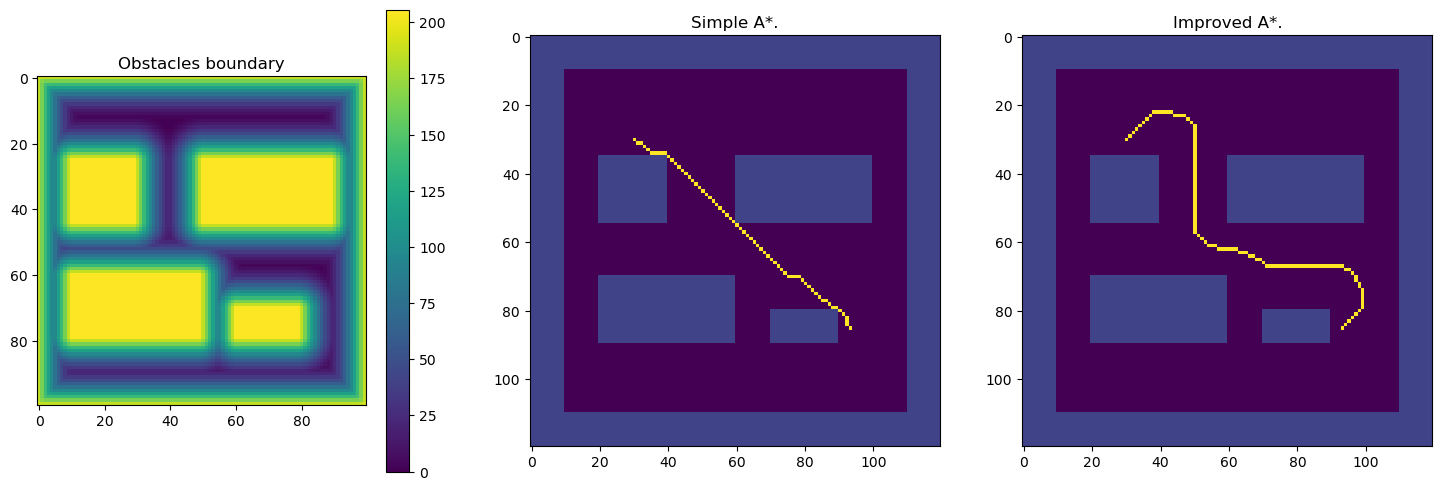

In [7]:
# Create gridmap
grid = np.zeros((400,400))
grid[0:120,  0:10] = 1
grid[0:10,  0:120] = 1
grid[110:120,  0:120] = 1
grid[0:120,  110:120] = 1
grid[35:55, 20:40] = 1
grid[70:90, 20:60] = 1
grid[35:55, 60:100] = 1
grid[80:90, 70:90] = 1
grid[120:,:] = 1
grid[:,120:] = 1

# Starting and final point
p1 = np.array([30,30])
p2 = np.array([85,93])

# Get costmap with Fast Marching Method. Library needs gridmap with zeros as obstacles
GRIDCOSTMAP1 = skfmm.distance(1-grid)
GRIDCOSTMAP1 = np.clip(np.square(np.max(GRIDCOSTMAP1) - GRIDCOSTMAP1), a_min=0, a_max = np.inf)

# Simple A* with no costmap
res = A_STAR(grid, GRIDCOSTMAP1, p1, p2, k=0)
grid *= 2  #Visualization purposes
simple = copy(grid)
path_mark  = 10
for p in res:
    simple[p[0], p[1]] = path_mark 

# With potential cost map

fig, axs = plt.subplots(1,3, figsize=(18,6))
im1 = axs[0].imshow(GRIDCOSTMAP1[10:110,10:110], interpolation='None')
fig.colorbar(im1, ax=axs[0])
axs[0].set_title('Obstacles boundary')

axs[1].set_title("Simple A*.")
axs[1].imshow(simple[:120, :120])

res = A_STAR(grid, GRIDCOSTMAP1, p1, p2, k=20)
new = copy(grid)
for p in res:
    new[p[0], p[1]] = path_mark
axs[2].set_title("Improved A*.")
axs[2].imshow(new[0:120, 0:120])
    
